In [3]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import torchvision
import torchvision.transforms as T

import copy

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")
import pandas as pd

C:\Users\Admin\AppData\Local\Temp\ipykernel_7180\686427741.py:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")


In [4]:
## MNIST data

data = pd.read_csv("../FFN/mnist_train_small.csv", header=None)

# don't need labels
labelsT = torch.tensor(data.values[:, 0]).long()
data = data.values[:, 1:]

# normalize the data to a range of [0 1]
dataNorm = data/np.max(data)

# New: reshape to 2D!
dataNormT = torch.tensor(dataNorm.reshape(dataNorm.shape[0], 1, 28, 28)).float()

# Step 2: use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataNormT, labelsT, test_size = .1)

# Step 3: convert into Pytorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Step 4: translate into dataloader objects
batchsize = 32
numbers_train_loader = DataLoader(train_data, batch_size = batchsize, shuffle = True, drop_last = True)
numbers_test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0])

In [5]:
## FMNIST data

# transformations
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(.5, .5)
])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,  download=True, transform=transform)
testset  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# transform to dataloaders
batchsize    = 32
fashion_train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
fashion_test_loader  = DataLoader(testset, batch_size=len(testset))

100%|█████████████████████████████████████████████████████████████████████████████| 26.4M/26.4M [00:08<00:00, 3.27MB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 176kB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 4.42M/4.42M [00:02<00:00, 1.76MB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 18.6MB/s]


In [6]:
def createTheMNISTNet(printtoggle = False):

    class mnistNet(nn.Module):
        def __init__(self, printtoggle):
            super().__init__()

            # convolution layers
            self.conv1 = nn.Conv2d(1, 10, kernel_size = 5, stride = 1, padding = 1)
            # size: np.floor((28 + 2 * 1 - 5) / 1) + 1 = 26/2 = 13 (/2 b/c of maxpool)

            self.conv2 = nn.Conv2d(10, 20, kernel_size = 5, stride = 1, padding = 1)
            # size: np.floor((13 + 2 * 1 - 5) / 1) + 1 = 11/2 = 5 (/2 b/c of maxpool)

            # compute the number of units in FCLayer (number of outputs conv2)
            expectSize = np.floor((5 + 2 * 0 - 1)/1) + 1 # fc1 layer has no padding or kernel, so set to 0/1
            expectSize = 20 * int(expectSize**2)

            # fully connected layer
            self.fc1 = nn.Linear(expectSize, 50)

            # output layer
            self.out = nn.Linear(50, 10)
 
            # toggle for printing out tensor sizes during forward propogation
            self.print = printtoggle

        # forward pass
        def forward(self, x):

            print(f"Input: {x.shape}") if self.print else None

            # convolution -> maxpool -> relu
            x = F.relu(F.max_pool2d(self.conv1(x), 2))
            print(f"Layer conv1/pool1: {x.shape}") if self.print else None

            # and again: convolution -> maxpool -> relu
            x = F.relu(F.max_pool2d(self.conv2(x), 2))
            print(f"Layer conv2/pool2: {x.shape}") if self.print else None

            # reshape for linear layer
            nUnits = x.shape.numel()/x.shape[0]
            # x.numel() = 32 * 20 * 5 * 5 = 16000
            # x.numel()/x.shape[0] = 16000/32 = 500
            x = x.view(-1, int(nUnits))
            # x.view(-1, 500) becomes x.view(32, 500)
            if self.print: print(f"Vectorize: {x.shape}")

            # linear layers
            x = F.relu(self.fc1(x))
            if self.print: print(f"Layer fc1: {x.shape}")
            x = self.out(x)
            if self.print: print(f"Layer out: {x.shape}")
            
            return x

    # create the model instance
    net = mnistNet(printtoggle)

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr = .001)

    return net, lossfun, optimizer

In [7]:
 # train the model

def trainTheModel(net, train_loader, test_loader, numepochs = 10):
    
    trainAcc = []
    testAcc = []
    losses = torch.zeros(numepochs)
    
    # train the model
    for epochi in range(numepochs):
        
        # loop over training data batches
        net.train()
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute training accuracy for this batch
            matches = torch.argmax(yHat, axis = 1) == y # booleans (false/true); selects the class with the highest predicted probability for each input.
            # The == operator compares the predicted class to the actual class, returning a Boolean tensor (True for correct predictions, False for incorrect).
            matchesNumeric = matches.float() # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # avg and * by 100
            batchAcc.append(accuracyPct)
            
        # now that we've trained through the batches, get avg training accuracy
        trainAcc.append(np.mean(batchAcc))

        # get avg losses over the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        net.eval()
        X, y = next(iter(test_loader))  # extract X, y from test dataloader
        with torch.no_grad(): # deactivates grad
            yHat = net(X)

        # compute test accuracy
        testAcc.append(100 * torch.mean((torch.argmax(yHat, axis = 1) == y).float()))
        
    # function output
    return trainAcc, testAcc, losses, net

In [8]:
# create a new model
numberNet, lossfun, optimizer = createTheMNISTNet()

# train it on numbers data
trainAcc, testAcc, losses, numberNet = trainTheModel(numberNet, numbers_train_loader, numbers_test_loader, 5)

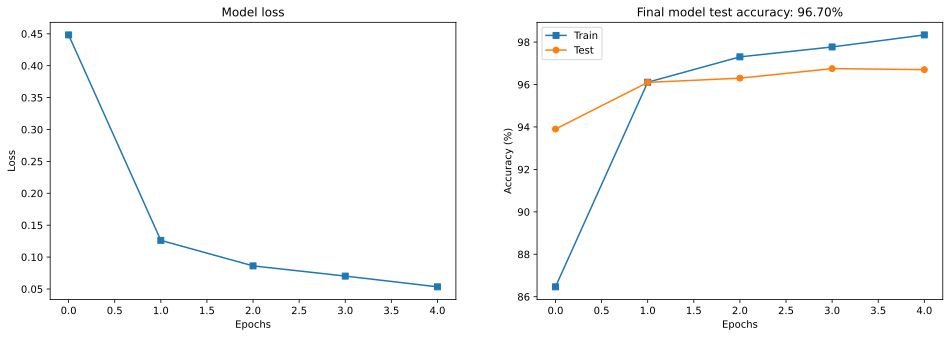

In [9]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [11]:
# test the model with fashion data

# extract X, y from FASHION test dataloader
X, y = next(iter(fashion_test_loader))
yHat = numberNet(X)

# the test
fashionAcc = 100*torch.mean((torch.argmax(yHat, axis = 1) == y).float())

print(f"NUMBERNET performance on FASHION data: {fashionAcc: .2f}%")

NUMBERNET performance on FASHION data:  4.59%


In [12]:
# fine-tune the model with one training batch

# create the target model
fashionNet, lossfun, optimizer = createTheMNISTNet()

# then replace all weights in TARGET model from SOURCE model
for target, source in zip(fashionNet.named_parameters(), numberNet.named_parameters()):
    target[1].data = copy.deepcopy(source[1].data)

In [13]:
# now re-train the network on the numbers data

trainAcc, testAcc, losses, fashionNet = trainTheModel(fashionNet, fashion_train_loader, fashion_test_loader, 1)

In [15]:
print(f"fashionNet TRAIN ACCURACY: {trainAcc[-1]: .2f}%")
print(f"fashionNet TEST ACCURACY: {testAcc[-1]: .2f}%")

fashionNet TRAIN ACCURACY:  81.36%
fashionNet TEST ACCURACY:  86.21%
